# Predictive Modelling for Lung Cancer Treatment Selection Based on Molecular Profile

# Anastasiia Deviataieva

## Import Packages Etc

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd                       # Core data-frame operations: loading, cleaning, reshaping tabular data
import numpy as np                        # Fast numerical routines (arrays, random numbers, linear algebra) used throughout the pipeline
import matplotlib.pyplot as plt           # Producing static plots (e.g., accuracy curves, confusion matrices)
#%matplotlib inline                        # Jupyter magic so matplotlib figures render inside the notebook
import seaborn as sns                     # Higher-level statistical graphics (heatmaps, pairplots)
import sklearn                            # Umbrella import for scikit-learn
import random                             # Python’s built-in RNG; I seed it for reproducibility
import inspect                            # Introspecting objects (e.g., printing model signatures, checking fitted attributes)
import pickle                             # Serialising trained models, grids or preprocessors to disk
import time                               # Simple timing (e.g., measuring fit / inference speed)
!pip install aeon                         # Ensures Aeon is present in the runtime
import aeon                               # Time-series toolkit (e.g., specialised classifiers, transformers)
import aeon.benchmarking.stats            # Helper functions for statistical tests across multiple TS experiments
import aeon.visualisation                 # Plotting utilities tailored to Aeon’s time-series objects
import itertools                          # Tools like product, combinations for manual hyper-parameter grids

!pip install -U catboost                                # Ensures CatBoost is kept up-to-date
from catboost import CatBoostClassifier   # Gradient-boosted decision trees with good categorical support
from sklearn.linear_model import LogisticRegression     # Baseline linear classifier for tabular data
from sklearn.naive_bayes import BernoulliNB             # Simple NB model for binary / sparse features
from sklearn.base import BaseEstimator, ClassifierMixin # Building custom scikit-learn-compatible wrappers
from sklearn.tree import DecisionTreeClassifier         # Single-tree model (baseline / feature importance)
from sklearn.svm import SVC                             # Support-vector machine for smaller dense datasets
from sklearn import metrics                             # Namespace import (gives metrics.confusion_matrix, roc_auc, etc.)
from sklearn.metrics import classification_report, accuracy_score, f1_score  # Key evaluation metrics
from sklearn.model_selection import train_test_split, cross_val_score, ParameterGrid, GridSearchCV, cross_validate # Data splitting and model-selection tools
from sklearn.ensemble import RandomForestClassifier     # Bagged trees for strong non-linear baseline
from sklearn.datasets import load_wine, load_iris, load_digits, fetch_openml # Toy datasets used for quick sanity checks
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted # Internal validators inside custom estimator classes
from sklearn.preprocessing import LabelEncoder, MinMaxScaler   # Encoding categorical labels & scaling numeric ranges
from sklearn.impute import SimpleImputer               # Filling in missing values in feature matrix
from sklearn.utils import Bunch                        # Lightweight dict-like container for custom datasets
from tabulate import tabulate                          # Pretty-print tables (e.g., CV scores) in notebook/console

import tarfile                                         # Extracting compressed archives—useful for dataset bundles
from pathlib import Path                               # Object-oriented filesystem paths (cross-platform)
from IPython.display import display                    # Rich display of DataFrames/HTML inside Jupyter

# Reproducibility
SEED = 14
random.seed(SEED)
np.random.seed(SEED)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 59.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 29.3 MB/s eta 0:00:00


## Preprocess and setup datasets

### MSK-CHORD (MSK, Nature 2024)

[Dataset link](https://www.cbioportal.org/study/summary?id=msk_chord_2024)

In [3]:
# ---------------------------------------------------------------
#   Study archive: extract and resolve base folder
# ---------------------------------------------------------------
archive2 = Path("/content/drive/MyDrive/PM_task5/msk_chord_2024.tar")
with tarfile.open(archive2, "r:*") as t2:
    t2.extractall(archive2.parent, filter="fully_trusted") # Unpack the .tar archive into the same directory
base2 = archive2.with_suffix("")                           # Base directory that holds the extracted study files

#  Load study tables
clinical_2 = pd.read_csv(base2 / "data_clinical_patient.txt", sep="\t", skiprows=4, dtype=str, low_memory=False)
clinical_sample_2 = pd.read_csv(base2 / "data_clinical_sample.txt", sep="\t", skiprows=4, dtype=str, low_memory=False)
mut_2 = pd.read_csv(base2 / "data_mutations.txt", sep="\t", dtype=str, low_memory=False)
treatment_2 = pd.read_csv(base2 / "data_timeline_treatment.txt", sep="\t", dtype=str, low_memory=False)

# ---------------------------------------------------------------
#   Keep only LUAD samples from data_clinical_sample.txt
# ---------------------------------------------------------------
# Normalize key fields to avoid whitespace issues
for col in ["PATIENT_ID", "ONCOTREE_CODE"]:
    if col in clinical_sample_2.columns:
        clinical_sample_2[col] = clinical_sample_2[col].astype(str).str.strip()

# Filter anf drop the code column after filtering
clinical_sample_2 = clinical_sample_2[clinical_sample_2["ONCOTREE_CODE"] == "LUAD"].drop(columns=["ONCOTREE_CODE"]).copy()
# Patient IDs present in LUAD-only samples
luad_patient_ids = (clinical_sample_2["PATIENT_ID"].dropna().astype(str).str.strip().unique().tolist())

# Subset by luad_patient_ids
clinical_2 = clinical_2[clinical_2["PATIENT_ID"].astype(str).str.strip().isin(luad_patient_ids)].copy()
treatment_2 = treatment_2[treatment_2["PATIENT_ID"].astype(str).str.strip().isin(luad_patient_ids)].copy()
#  mut_2 → PATIENT_ID is embedded in the beginning of Tumor_Sample_Barcode
#    Example: "P-0089148-T01-IM7" → take first 9 chars → "P-0089148"
#    Keep only those where this prefix is in luad_patient_ids.
mut_2 = mut_2[mut_2["Tumor_Sample_Barcode"].astype(str).str.strip().str.slice(0, 9).isin(luad_patient_ids)
].copy()

# Quick shapes and display
for name, df in [
    ("Clinical data ", clinical_2),
    ("Clinical sample data ", clinical_sample_2),
    ("Mutations data", mut_2),
    ("Timelines and treatments data", treatment_2)]:
    print(f"{name} \n Shape: {df.shape}")
    display(df.head())

Clinical data  
 Shape: (5957, 26)


,PATIENT_ID,GENDER,RACE,ETHNICITY,CURRENT_AGE_DEID,STAGE_HIGHEST_RECORDED,NUM_ICDO_DX,ADRENAL_GLANDS,BONE,CNS_BRAIN,...,REPRODUCTIVE_ORGANS,SMOKING_PREDICTIONS_3_CLASSES,GLEASON_FIRST_REPORTED,GLEASON_HIGHEST_REPORTED,HISTORY_OF_PDL1,PRIOR_MED_TO_MSK,OS_MONTHS,OS_STATUS,HR,HER2
0,P-0000012,Female,White,Non-Spanish; Non-Hispanic,68,Stage 1-3,2,No,No,No,...,No,Former/Current Smoker,NaN,NaN,No,Unknown,118.4546647,0:LIVING,No,No
2,P-0000036,Female,Other,Non-Spanish; Non-Hispanic,68,Stage 4,1,No,Yes,No,...,No,Never,NaN,NaN,NaN,Unknown,115.4628872,0:LIVING,NaN,NaN
25,P-0000082,Male,White,Non-Spanish; Non-Hispanic,70,Stage 1-3,1,No,Yes,No,...,No,Former/Current Smoker,NaN,NaN,NaN,Unknown,116.2190507,0:LIVING,NaN,NaN
28,P-0000110,Male,White,Non-Spanish; Non-Hispanic,75,Stage 4,1,No,Yes,Yes,...,No,Former/Current Smoker,NaN,NaN,NaN,Unknown,47.93419404,1:DECEASED,NaN,NaN
37,P-0000133,Female,White,Non-Spanish; Non-Hispanic,83,Stage 1-3,3,Yes,Yes,No,...,No,Never,NaN,NaN,NaN,Unknown,19.59449907,1:DECEASED,NaN,NaN


Clinical sample data  
 Shape: (5957, 23)


,SAMPLE_ID,PATIENT_ID,GLEASON_SAMPLE_LEVEL,PDL1_POSITIVE,CANCER_TYPE,SAMPLE_TYPE,SAMPLE_CLASS,METASTATIC_SITE,PRIMARY_SITE,CANCER_TYPE_DETAILED,...,MSI_COMMENT,MSI_SCORE,MSI_TYPE,SOMATIC_STATUS,CLINICAL_GROUP,PATHOLOGICAL_GROUP,CLINICAL_SUMMARY,ICD_O_HISTOLOGY_DESCRIPTION,DIAGNOSIS_DESCRIPTION,TMB_NONSYNONYMOUS
0,P-0000012-T03-IM3,P-0000012,NaN,NaN,Non-Small Cell Lung Cancer,Metastasis,Tumor,Neck,Lung,Lung Adenocarcinoma,...,MICROSATELLITE STABLE (MSS). See MSI note below.,0.47,Stable,Matched,3B,NaN,Distant,"Adenocarcinoma, Nos",Lung and Bronchus,32.16550372
3,P-0000036-T01-IM3,P-0000036,NaN,NaN,Non-Small Cell Lung Cancer,Primary,Tumor,Not Applicable,Lung,Lung Adenocarcinoma,...,NaN,-1,Do not report,Unmatched,4,NaN,Distant,"Adenocarcinoma, Nos",Lung and Bronchus,7.764087104
26,P-0000082-T01-IM3,P-0000082,NaN,NaN,Non-Small Cell Lung Cancer,Primary,Tumor,Not Applicable,Lung,Lung Adenocarcinoma,...,MICROSATELLITE STABLE (MSS). See MSI note below.,0.26,Stable,Matched,2A,NaN,"Regional,Lymph Nodes Only",Adenocarcinoma Combined With Other Types Of Ca...,Lung and Bronchus,13.30986361
29,P-0000110-T01-IM3,P-0000110,NaN,NaN,Non-Small Cell Lung Cancer,Primary,Tumor,Not Applicable,Lung,Lung Adenocarcinoma,...,Not Available,0.44,Stable,Matched,4,4,Distant,"Adenocarcinoma, Nos",Lung and Bronchus,16.63732951
38,P-0000133-T01-IM3,P-0000133,NaN,NaN,Non-Small Cell Lung Cancer,Primary,Tumor,Not Applicable,Lung,Lung Adenocarcinoma,...,Not Available,0,Stable,Matched,3A,NaN,Distant,"Adenocarcinoma, Nos",Lung and Bronchus,4.436621202


Mutations data 
 Shape: (48083, 123)


,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Consequence,Variant_Classification,...,VARIANT_CLASS,all_effects,amino_acid_change,cDNA_Change,cDNA_position,cdna_change,comments,n_depth,t_depth,transcript
0,EGFR,1956,MSKCC,GRCh37,7,55242470,55242487,+,inframe_deletion,In_Frame_Del,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PDGFRB,5159,MSKCC,GRCh37,5,149513271,149513271,+,missense_variant,Missense_Mutation,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,RBM10,8241,MSKCC,GRCh37,X,47041565,47041598,+,frameshift_variant,Frame_Shift_Del,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,CUL3,8452,MSKCC,GRCh37,2,225376137,225376137,+,missense_variant,Missense_Mutation,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,SETD2,29072,MSKCC,GRCh37,3,47139455,47139462,+,frameshift_variant,Frame_Shift_Del,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Timelines and treatments data 
 Shape: (22695, 8)


,PATIENT_ID,START_DATE,STOP_DATE,EVENT_TYPE,SUBTYPE,AGENT,RX_INVESTIGATIVE,FLAG_OROTOPICAL
0,P-0000012,-5437,-5369,Treatment,Chemo,CYCLOPHOSPHAMIDE,N,0
1,P-0000012,-5437,-5326,Treatment,Chemo,FLUOROURACIL,N,0
2,P-0000012,-5437,-5327,Treatment,Chemo,METHOTREXATE,N,0
3,P-0000012,33,40,Treatment,Chemo,CISPLATIN,N,0
4,P-0000012,33,65,Treatment,Chemo,ETOPOSIDE,N,0


In [4]:
# Print colnames for each data
# for name, df in [
#    ("Clinical data", clinical_2),
#    ("Clinical sample data", clinical_sample_2),
#    ("Mutations data", mut_2),
#    ("Timelines and treatments data", treatment_2)]:

#    cols = df.columns.tolist()
#    print(f"{name} \n{len(cols)} columns:")
#    print(", ".join(cols))
#   print()

In [5]:
# ---------------------------------------------------------------
#   Mutation data preprocessing
# ---------------------------------------------------------------
# Build a wide **binary** matrix with **patients as rows** and **genes as columns**.
# Per your requirement, we trim Tumor_Sample_Barcode to the first 9 chars (patient ID)
# BEFORE pivoting, so columns are genes and rows are P-XXXXXXX patients.

# Keep only the two key columns and normalize whitespace
mut_pair = (mut_2[["Hugo_Symbol", "Tumor_Sample_Barcode"]].dropna().astype(str).apply(lambda s: s.str.strip()))

# Trim Tumor_Sample_Barcode to the first 9 chars (patient prefix)
mut_pair.loc[:, "Tumor_Sample_Barcode"] = mut_pair["Tumor_Sample_Barcode"].str.slice(0, 9)

#Count records per (patient, gene) and pivot → patients x genes
mut_counts = (mut_pair.groupby(["Tumor_Sample_Barcode", "Hugo_Symbol"]).size().unstack(fill_value=0))
mutations_raw = (mut_counts > 0).astype("int8") # Convert counts to binary 0/1 (any non-zero becomes 1)

print("mutations_raw (patients x genes) → shape:", mutations_raw.shape)
display(mutations_raw.head(7))

# Sum down the rows (patients) for each gene/column and sort descending.
# This is the number of LUAD patients mutated per gene.
print("\nGene mutation counts (Top 15 displayed, descending):")
display(mutations_raw.sum(axis=0).sort_values(ascending=False).to_frame(name="count").head(15))


# === Drop genes mutated in <=5% of the cohort ============================
# Compute per-gene mutation frequency across patients and keep columns with >=5%.
# Minimize intermediates: build a boolean mask once, report kept/total, filter in place.

mask = mutations_raw.sum(axis=0) > 0.05 * len(mutations_raw)
print(f"\nAfter 5% frequency filter: kept {int(mask.sum())} / {mask.size} genes (>=5%).")
mutations_raw = mutations_raw.loc[:, mask]

# Show a small preview after filtering
# display(mutations_raw.head(7))


mutations_raw (patients x genes) → shape: (5724, 515)


Hugo_Symbol,ABL1,AC004906.3,AC008738.1,ACVR1,AGO2,AKT1,AKT2,AKT3,ALB,ALK,...,WT1,WWTR1,XIAP,XPO1,XRCC2,YAP1,YES1,ZFHX3,ZNRF3,ZRSR2
Tumor_Sample_Barcode,,,,,,,,,,,,,,,,,,,,,
P-0000012,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P-0000036,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P-0000082,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P-0000110,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
P-0000133,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P-0000149,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P-0000165,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



Gene mutation counts (Top 15 displayed, descending):


,count
Hugo_Symbol,
TP53,2707
KRAS,1933
EGFR,1762
STK11,844
KEAP1,763
RBM10,696
PTPRD,490
ATM,435
SMARCA4,434



After 5% frequency filter: kept 23 / 515 genes (>=5%).


In [6]:
# ---------------------------------------------------------------
#    Creating final table with MSK dataset
# ---------------------------------------------------------------
# ===  Mutation data + treatment info  ==========================

MSK = mutations_raw.copy()

# Turn the index into a proper column named 'Tumor_Sample_Barcode'
MSK = MSK.rename_axis("Tumor_Sample_Barcode").reset_index()

# Prepare per-patient labels from the treatment timeline:
#    - sort each patient's rows by START_DATE (these are RELATIVE DAYS, not calendar dates)
#    - for each patient, concatenate unique SUBTYPEs and AGENTs in chronological order using '+'
t = treatment_2[["PATIENT_ID", "SUBTYPE", "AGENT", "START_DATE"]].copy()
# Collapse SUBTYPE into buckets to prefent to mess of many classes:
# Targeted, Biologic → Molecular
# Hormone, Bone Treatment → Supportive
map_subtype = {
    "Targeted": "Molecular",
    "Biologic": "Molecular",
    "Hormone": "Supportive",
    "Bone Treatment": "Supportive"}
t["SUBTYPE"] = t["SUBTYPE"].replace(map_subtype)
t["PATIENT_ID"] = t["PATIENT_ID"].astype(str).str.strip()
t["START_DATE"] = pd.to_numeric(t["START_DATE"], errors="coerce")  # relative days (can be negative)
t = t.sort_values(["PATIENT_ID", "START_DATE"], na_position="last")


def cat_plus(s):
    """
    Concatenate unique, non-empty values with '+', preserving first-seen order.
    Assumes rows for this patient are already sorted by START_DATE above.
    Returns pd.NA if nothing remains after cleaning.

    """
    vals = [x for x in s.astype(str).str.strip() if x and x.lower() != "nan"]
    seen, out = set(), []
    for v in vals:
        if v not in seen:
            seen.add(v); out.append(v)
    return "+".join(out) if out else pd.NA


# Build one row per patient with two columns:
#   - TREATMENT: concatenated SUBTYPEs
#   - AGENTS:    concatenated AGENTs
labels = (
    t.groupby("PATIENT_ID", as_index=True)
     .agg({"SUBTYPE": cat_plus, "AGENT": cat_plus})
     .rename(columns={"SUBTYPE": "TREATMENT", "AGENT": "AGENTS"}))

# Attach labels to MSK by matching Tumor_Sample_Barcode (left) to PATIENT_ID (right).
# how='inner' keeps ONLY patients that have at least one treatment row
MSK = MSK.merge(labels, left_on="Tumor_Sample_Barcode", right_index=True, how="inner")
# Move ID and label columns to the front for readability
MSK = MSK[["Tumor_Sample_Barcode", "TREATMENT", "AGENTS"] +
          [c for c in MSK.columns if c not in ("Tumor_Sample_Barcode","TREATMENT","AGENTS")]]


# Canonical order of components inside TREATMENT.
# The goal is to make logically identical sets look identical, e.g.
# 'Immuno+Chemo' and 'Chemo+Immuno' -> 'Chemo+Immuno'.
ORDER = ["Chemo", "Immuno", "Molecular", "Supportive", "Investigational"]


def normalize_treatment(s):
    """
    Normalize a TREATMENT string by:
      1) splitting by '+'
      2) removing duplicates while preserving first occurrence
      3) sorting components by the fixed ORDER above
      4) joining back with '+'
    """
    if pd.isna(s) or str(s).strip() == "":
        return pd.NA
    parts = [p.strip() for p in str(s).split("+") if p.strip()]
    # remove duplicates, keep first occurrence
    seen, uniq = set(), []
    for p in parts:
        if p not in seen:
            seen.add(p); uniq.append(p)
    # sort by ORDER; unknown tokens (if any) go to the end alphabetically
    parts_sorted = sorted(uniq, key=lambda x: (ORDER.index(x) if x in ORDER else len(ORDER), x))
    return "+".join(parts_sorted)


# Apply normalization ONLY to TREATMENT; AGENTS remain untouched
MSK["TREATMENT"] = MSK["TREATMENT"].apply(normalize_treatment)

# Quick sanity checks
# print(MSK["TREATMENT"].value_counts(dropna=False).to_string())
# display(MSK.head(20))
# MSK.shape

In [7]:
# ===  MSK + patient data  =======================================================
# Add clinical attributes to MSK from clinical_2
need = [
    "PATIENT_ID",
    "GENDER",
    "RACE",
    "CURRENT_AGE_DEID",
    "STAGE_HIGHEST_RECORDED",
    "NUM_ICDO_DX",
    "SMOKING_PREDICTIONS_3_CLASSES",
    "OS_MONTHS",
    "OS_STATUS"]

# One row per patient; keep only the requested clinical columns
clin = clinical_2[need].drop_duplicates(subset=["PATIENT_ID"], keep="first")

# Join by patient ID:
# - left key: MSK["Tumor_Sample_Barcode"]
# - right key: clin["PATIENT_ID"]
# Using how="inner" keeps only patients present in BOTH MSK and clinical_2
MSK = (MSK.merge(clin, left_on="Tumor_Sample_Barcode",
                 right_on="PATIENT_ID", how="inner").drop(columns=["PATIENT_ID"]))

# Move the clinical columns just after TREATMENT/AGENTS for readability
front = ["Tumor_Sample_Barcode", "TREATMENT", "AGENTS"] + need[1:]
MSK = MSK[front + [c for c in MSK.columns if c not in front]]

display(MSK.head(20))
print(MSK.shape)

# Save to CSV (next to extracted study folder)
MSK.to_csv(base2.parent / "MSK_CHORD.csv", index=False)
print(f'Saved MSK → {base2.parent / "MSK_CHORD.csv"}')

,Tumor_Sample_Barcode,TREATMENT,AGENTS,GENDER,RACE,CURRENT_AGE_DEID,STAGE_HIGHEST_RECORDED,NUM_ICDO_DX,SMOKING_PREDICTIONS_3_CLASSES,OS_MONTHS,...,NF1,NTRK3,PIK3CA,PTPRD,PTPRT,RBM10,SETD2,SMARCA4,STK11,TP53
0,P-0000012,Chemo+Immuno+Investigational,CYCLOPHOSPHAMIDE+FLUOROURACIL+METHOTREXATE+CIS...,Female,White,68,Stage 1-3,2,Former/Current Smoker,118.4546647,...,0,0,0,1,1,0,0,1,0,1
1,P-0000036,Chemo+Molecular,BEVACIZUMAB+CARBOPLATIN+PEMETREXED+CRIZOTINIB,Female,Other,68,Stage 4,1,Never,115.4628872,...,0,0,0,0,0,0,0,0,0,1
2,P-0000082,Chemo+Molecular+Supportive+Investigational,BEVACIZUMAB+PEMETREXED+DOCETAXEL+INVESTIGATION...,Male,White,70,Stage 1-3,1,Former/Current Smoker,116.2190507,...,0,0,0,0,0,0,0,0,0,1
3,P-0000110,Chemo+Molecular+Supportive,BEVACIZUMAB+PACLITAXEL+PEMETREXED+ZOLEDRONIC ACID,Male,White,75,Stage 4,1,Former/Current Smoker,47.93419404,...,0,0,0,1,0,0,0,0,0,1
4,P-0000133,Chemo+Supportive,LETROZOLE+GEMCITABINE+VINORELBINE,Female,White,83,Stage 1-3,3,Never,19.59449907,...,0,0,1,0,0,0,0,0,0,1
5,P-0000149,Chemo+Molecular+Supportive+Investigational,INVESTIGATIONAL+ZOLEDRONIC ACID+CARBOPLATIN+PE...,Female,Black Or African American,52,Stage 4,2,Former/Current Smoker,18.73970549,...,0,0,0,0,0,0,1,0,0,0
6,P-0000165,Chemo+Immuno+Molecular,CARBOPLATIN+PEMETREXED+GEMCITABINE+ERLOTINIB+D...,Female,White,68,Stage 4,2,Never,15.68217459,...,0,0,0,0,0,0,0,0,0,1
7,P-0000205,Chemo+Molecular+Investigational,CISPLATIN+PEMETREXED+INVESTIGATIONAL+ERLOTINIB,Female,White,56,Stage 1-3,1,Unknown,3.747941098,...,0,0,0,0,0,0,0,0,0,0
8,P-0000208,Molecular+Investigational,INVESTIGATIONAL+CABOZANTINIB,Female,White,69,Stage 4,3,Unknown,13.21642387,...,0,0,0,0,0,0,0,0,0,0
9,P-0000219,Chemo+Supportive,CISPLATIN+VINORELBINE+ZOLEDRONIC ACID,Female,White,64,Stage 1-3,1,Former/Current Smoker,113.9176834,...,0,0,0,0,0,0,0,0,0,0


(4463, 34)
Saved MSK → /content/drive/MyDrive/PM_task5/MSK_CHORD.csv


In [8]:
# --------------------------------------------------------------------------
#  Load saved MSK-CHORD table and preprocess before classification
# --------------------------------------------------------------------------
# Load the table you previously saved next to base2 (parent folder)
mMSK = pd.read_csv('/content/drive/MyDrive/PM_task5/MSK_CHORD.csv')

mMSK = mMSK.drop(columns=["GENDER"], errors="ignore") #comment this and uncomment next block to have GENDER as feature
# === Binary encode GENDER =================================================
# Normalize case/whitespace, then map Female → 1; Male/Unknown → 0
# mMSK["GENDER"] = (mMSK["GENDER"].astype(str).str.strip().str.title()
#                  .map({"Female": 1, "Male": 0, "Unknown": 0}).fillna(0).astype("int8"))

# === Smoking and Stage: single binary features  ===========================
# SMOKER = 1 if "Former/Current Smoker", else 0 (Never/Unknown).
mMSK["SMOKER"] = (mMSK["SMOKING_PREDICTIONS_3_CLASSES"].astype(str).str.strip().eq("Former/Current Smoker")).astype("int8")
# STAGE_GE4 = 1 if "Stage 4", else 0 (Stage 1–3/Unknown).
mMSK["STAGE_GE4"] = (mMSK["STAGE_HIGHEST_RECORDED"].astype(str).str.strip().eq("Stage 4")).astype("int8")



# Remove columns that are IDs, outcome/leakage, or replaced by derived features
mMSK = mMSK.drop(columns=["STAGE_HIGHEST_RECORDED", "SMOKING_PREDICTIONS_3_CLASSES",
                          "Tumor_Sample_Barcode", "AGENTS", "OS_MONTHS", "OS_STATUS"], errors="ignore")

mMSK = mMSK.drop(columns=["RACE"], errors="ignore") #comment this and uncomment next block to have RACE as feature
# === RACE: clean labels, then one-hot to 0/1 dummies ======================
# Collapse specific responses to "Unknown", then expand into binary columns.
# mMSK["RACE"] = (mMSK["RACE"].astype(str).str.strip().replace({"Pt Refused To Answer": "Unknown",
#                                                              "No Value Entered": "Unknown",
#                                                              "Native American-Am Ind/Alaska": "Other",
#                                                              "Native Hawaiian Or Pacific Isl": "Other"}))
# print(mMSK["RACE"].value_counts(dropna=False).to_string())
# mMSK = pd.get_dummies(mMSK, columns=["RACE"], prefix="RACE", dtype="int8")

# === Numeric scaling with sklearn (median impute → MinMax[0,1]) ===========
# Convert to numeric, impute missing values by the median, then scale to [0,1].
num_cols = ["CURRENT_AGE_DEID", "NUM_ICDO_DX"]
mMSK[num_cols] = MinMaxScaler().fit_transform(SimpleImputer(strategy="median").fit_transform(
    mMSK[num_cols].apply(pd.to_numeric, errors="coerce")))
# print("Scaled ranges:", {c: (float(mMSK[c].min()), float(mMSK[c].max())) for c in num_cols})

mMSK_2 = mMSK.copy() # Creating second dataset

# === Target label TREATMENT: keep only the most frequent categories =======
# Compute the top-N most frequent TREATMENT values (here N=10).
# Any TREATMENT not in this top list will be collapsed into "Other".
topN = mMSK["TREATMENT"].value_counts(dropna=False).head(10).index
mMSK["TREATMENT"] = mMSK["TREATMENT"].where(mMSK["TREATMENT"].isin(topN), "Other").fillna("Other")

display(mMSK.head(10))
print(mMSK.shape)

,TREATMENT,CURRENT_AGE_DEID,NUM_ICDO_DX,ARID1A,ATM,BRAF,CDKN2A,EGFR,EPHA3,EPHA5,...,PIK3CA,PTPRD,PTPRT,RBM10,SETD2,SMARCA4,STK11,TP53,SMOKER,STAGE_GE4
0,Other,0.700000,0.2,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,1,1,0
1,Chemo+Molecular,0.700000,0.1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,Other,0.728571,0.1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,Chemo+Molecular+Supportive,0.800000,0.1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,1,1
4,Other,0.914286,0.3,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
5,Other,0.471429,0.2,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1
6,Chemo+Immuno+Molecular,0.700000,0.2,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
7,Chemo+Molecular+Investigational,0.528571,0.1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Molecular+Investigational,0.714286,0.3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,Other,0.642857,0.1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


(4463, 28)


In [9]:
# ---------------------------------------------------------------------------------------------------------
# Smaller version of MSK-CHORD-LUAD ― filter to keep only the 5 treatment classes with single treatmet type
# ---------------------------------------------------------------------------------------------------------
# Specify the whitelist of therapeutic categories
valid_treatments = ["Chemo", "Immuno", "Molecular", "Supportive", "Investigational"]
# Sub-select rows whose TREATMENT label appears in the whitelist
mMSK_2 = mMSK_2[mMSK_2["TREATMENT"].isin(valid_treatments)]

display(mMSK_2.head(10))
# Inspect the new class distribution to spot potential imbalance
print(mMSK_2["TREATMENT"].value_counts(dropna=False).to_string())
mMSK_2.shape

,TREATMENT,CURRENT_AGE_DEID,NUM_ICDO_DX,ARID1A,ATM,BRAF,CDKN2A,EGFR,EPHA3,EPHA5,...,PIK3CA,PTPRD,PTPRT,RBM10,SETD2,SMARCA4,STK11,TP53,SMOKER,STAGE_GE4
13,Chemo,0.828571,0.4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
21,Chemo,0.728571,0.1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
24,Chemo,0.542857,0.1,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,1
25,Molecular,0.471429,0.1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
28,Chemo,0.600000,0.1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0
29,Chemo,0.685714,0.2,0,0,1,0,0,0,1,...,0,0,1,0,0,1,1,0,0,1
34,Molecular,0.900000,0.1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
41,Chemo,0.700000,0.2,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
47,Chemo,0.685714,0.1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
48,Chemo,0.814286,0.1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


TREATMENT
Chemo              624
Molecular          371
Immuno             124
Supportive          98
Investigational     83


(1300, 28)

### Setup Datasets

In [10]:
# Initialize an empty dictionary
datasets = dict()

# --- Split features/target for mMSK -------------------------------------------
X_cols = [c for c in mMSK.columns if c != "TREATMENT"]
X = mMSK[X_cols]

# Label-encode target to integers 0..C-1
le = LabelEncoder()
y = le.fit_transform(mMSK["TREATMENT"].astype(str)) # numeric target
class_map = {i: cls for i, cls in enumerate(le.classes_)}  # id -> label

# Pack to a scikit-like Bunch so .data/.target work like in load_* datasets
msk_bunch = Bunch(
    data=X.values,                 # numpy array of features
    target=y,                      # encoded target (ints)
    feature_names=X_cols,          # list of feature names
    target_names=le.classes_,      # original class labels (strings)
    frame=mMSK.copy())             # keep full dataframe if needed

# Register in your datasets dict
dataset_details = dict()
dataset_details["dataset"] = msk_bunch          # same key as for iris/digits
dataset_details["target_feature"] = "target"    # target is stored in .target
dataset_details["num_classes"] = len(le.classes_)
dataset_details["classes"] = class_map          # {0: 'Chemo', 1: 'Chemo+Immuno', ...}
dataset_details["target_column"] = "TREATMENT"  # (optional) original target name
datasets["msk_chord"] = dataset_details

# --- Split features/target for mMSK_2 -----------------------------------------
X_cols2 = [c for c in mMSK_2.columns if c != "TREATMENT"]
X2 = mMSK_2[X_cols2]

# Label-encode target to integers 0..C-1
le2 = LabelEncoder()
y2 = le2.fit_transform(mMSK_2["TREATMENT"].astype(str)) # numeric target
class_map2 = {i: cls for i, cls in enumerate(le2.classes_)}  # id -> label

# Pack to a scikit-like Bunch so .data/.target work like in load_* datasets
msk2_bunch = Bunch(
    data=X2.values,                 # numpy array of features
    target=y2,                      # encoded target (ints)
    feature_names=X_cols2,          # list of feature names
    target_names=le2.classes_,      # original class labels (strings)
    frame=mMSK_2.copy())             # keep full dataframe if needed

# Register in your datasets dict
dataset_details = dict()
dataset_details["dataset"] = msk2_bunch          # same key as for iris/digits
dataset_details["target_feature"] = "target"     # target is stored in .target
dataset_details["num_classes"] = len(le2.classes_)
dataset_details["classes"] = class_map2          # {0: 'Chemo', 1: 'Chemo+Immuno', ...}
dataset_details["target_column"] = "TREATMENT"   # (optional) original target name
datasets["msk_chord_filtered"] = dataset_details

# --- Digits dataset  ----------------------------------------------------------
# It serves as a lightweight reference dataset for quick debugging and validation of the entire ML pipeline
dataset_details = dict()
dataset_details["dataset"] = load_digits() # Load the Digits dataset from scikit-learn
dataset_details["target_feature"] = "target"
dataset_details["num_classes"] = 10 # Ten classes of digits 0-9
dataset_details["classes"] = {i: str(i) for i in range(10)} # Match numbers to their string
datasets["digits"] = dataset_details


## --- Fashion-MNIST dataset ----------------------------------------------------
###### Call following datasets using fetch_openml
#fashion_mnist = fetch_openml(name='Fashion-MNIST', version=1, as_frame=False) # Load Fashion-MNIST from OpenML, as_frame=False for NumPy array
#dataset_details = dict()
#dataset_details["dataset"] = fashion_mnist
#dataset_details["target_feature"] = "target"
#dataset_details["num_classes"] = 10
#dataset_details["classes"] = {
#    0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
#    5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"
#} # Label for each class
#datasets["fashion_mnist"] = dataset_details


# Output datasets' information
for name, details in datasets.items(): # Loop through all datasets and print names, number of classes, and sample size
    print(f"{name}: {details['num_classes']} classes, {details['dataset'].data.shape[0]} samples")

# Define `sampling_rates` for each dataset (make it smaller for quicker evaluation)
sampling_rates = {
    #"fashion_mnist": 0.1,
    "digits": 0.99
}


msk_chord: 11 classes, 4463 samples
msk_chord_filtered: 5 classes, 1300 samples
digits: 10 classes, 1797 samples


## Define HyperParamClassifier

HyperParamClassifier class.

In [11]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class HyperParamEnsembleClassifier(sklearn.base.BaseEstimator, sklearn.base.ClassifierMixin):
    """
    Ensemble classifier that trains multiple instances of a base model with different hyperparameter combinations.

    Parameters:
    ----------
    base_model: scikit-learn classifier (e.g., DecisionTreeClassifier)
        The base model to be used for training.
    param_grid: dict
        Dictionary of hyperparameter ranges.
    n_estimators: int, default=20
        Number of models in the ensemble.
    voting: {"hard", "soft"}, default="hard"
        Voting mechanism:
        - "hard": Majority voting.
        - "soft": Averaging predicted probabilities.
    random_state: int, default=42
        Random seed.

    Attributes:
    ----------
    models: list
        List of trained models.
    Notes
    -----
    This classifier is an ensemble method that trains multiple instances
    of a single base model with different hyperparameters. It uses a
    voting strategy for predictions.

    **What you need to know before using it:**

    1. **Base Model (`base_model`)**
       - Must be compatible with `scikit-learn`.
       - Must support the `fit()` and `predict()` methods.
       - If `voting="soft"` is used, the base model must also support `predict_proba()`.

    2. **Hyperparameter Grid (`param_grid`)**
       - Provided as a dictionary
       - If an empty grid `{}` is passed, a `ValueError` will be raised.
       - If the number of possible hyperparameter combinations is less than `n_estimators`,
         they will **repeat cyclically**.

    3. **Number of Models (`n_estimators`)**
       - **Specifies the number of individual models in the ensemble.**
       - **Not limited by the size of `param_grid`**—if there are fewer hyperparameter combinations than `n_estimators`, they will be repeated.
       - **If `n_estimators` is greater than the number of possible combinations,** parameters from `param_grid` will be reused cyclically.
       - **If `n_estimators` is smaller than the number of available combinations,** only the first `n_estimators` configurations will be selected.
       - **Must be a positive integer (`n_estimators > 0`)**—otherwise, a `ValueError` will be raised.

    4. **Voting Mechanism (`voting`)**
       - `"hard"` — majority voting (the most frequent class is chosen).
       - `"soft"` — probability averaging (requires `base_model` to support `predict_proba()`).
       - Any other value will raise a `ValueError`.

    5. **Reproducibility (`random_state`)**
       - If the `base_model` supports `random_state`, it will be set.
       - For consistent random choices (`tie-breaking` in hard voting), `numpy.random.default_rng(random_state)` is used.

    **Limitations:**
    - Does not support models that require special input formats (e.g., `SVM` without `kernel='linear'`).
    - With `voting="soft"`, errors will occur if `predict_proba()` is not available in the `base_model`.
    - `partial_fit()` is not supported—full retraining is required each time `fit()` is called.

    Example:
    --------
    parameter_grid = {                # Define parameters
        "n_estimators": [3, 5, 10],   # Number of trees
        "max_depth": [2, 4, 6],       # Tree depth
        "min_samples_split": [5, 10]} # Minimum number of samples to split
    wine = load_wine() # Load dataset
    X_train, X_test, y_train, y_test = train_test_split(
        wine.data, wine.target, test_size=0.35, random_state=42, stratify=wine.target)
    # Create and train the ensemble classifier
    ex = HyperParamEnsembleClassifier(RandomForestClassifier, parameter_grid, n_estimators=3)
    ex.fit(X_train, y_train)
    y_pred = ex.predict(X_test)# Make predictions
    print(metrics.classification_report(y_test, y_pred)) # Print classification report
    print("Confusion Matrix")
    display(pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
    """
    # Constructor for the classifier object
    def __init__(self, base_model, param_grid, n_estimators=20, voting="hard", random_state=42):
        self.base_model = base_model
        self.param_grid = param_grid
        self.n_estimators = n_estimators
        self.voting = voting
        self.random_state = random_state
        self.models = []  # List for storing models


    def fit(self, X, y):
        """
        Train an ensemble of models using different hyperparameter combinations.
        Parameters:
        ----------
        X : array-like, shape = [n_samples, n_features]
            The training input samples.
        y : array-like, shape = [n_samples]
            The target values (class labels) as integers or strings.
        Returns:
        -------
        self : object
            Returns the instance of the classifier.
        """
        X, y = check_X_y(X, y)  # Check that X and y have correct shape
        self.models.clear()     # Clear previous models if re-fitting
        # Check that hyperparameters are passed
        if not self.param_grid:
            raise ValueError("param_grid is empty. Please provide at least one valid hyperparameter range.")

        # Creating a list of all possible combinations of hyperparameters
        param_list = list(ParameterGrid(self.param_grid))
        # If the number of combinations is less than n_estimators, repeat them cyclically
        param_list = (param_list * ((self.n_estimators // len(param_list)) + 1))[:self.n_estimators]

        # Train models
        for params in param_list:
            model = self.base_model(**params)  # Creating a model with these parameters
            # If the model has a parameter random_state, set it for reproducibility
            if hasattr(model, 'set_params') and 'random_state' in model.get_params():
                model.set_params(random_state=self.random_state)
            model.fit(X, y)                    # Training the model
            self.models.append(model)          # Adding to the ensemble

        # Check that at least one model has been trained successfully
        if not self.models:
            raise RuntimeError("No models were successfully trained. Check your parameter grid.")

        return self


    def predict(self, X):
        """
        Predict class labels of the input samples X.
        Parameters:
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples.
        Returns:
        -------
        y_pred : array of shape = [n_samples, ].
            The predicted class labels of the input samples.
        """
        check_is_fitted(self, "models") # Check that the model is trained
        X = check_array(X)

        # Return the prediction made by the classifier
        predictions = np.array([model.predict(X) for model in self.models])  # (n_estimators, n_samples)

        # Hard Voting
        if self.voting == "hard":
            return np.apply_along_axis(self.most_common_with_tiebreak, axis=0, arr=predictions)
        # Soft Voting
        elif self.voting == "soft":
            probas = self.predict_proba(X)
            return np.argmax(probas, axis=1)
        else:
            raise ValueError("Voting must be 'hard' or 'soft'")


    def most_common_with_tiebreak(self, x):
        """
        Selects the most frequently occurring class in the predictions.
        In case of a tie, randomly selects one of the most frequent classes.
        Parameters:
        ----------
        x : array
            An array of predicted classes.
        Returns:
        -------
        int
            The most frequently occurring class (or a random class in case of a tie).
        """
        values, counts = np.unique(x, return_counts=True)
        max_count = np.max(counts)
        candidates = values[counts == max_count] # Select classes with the maximum number of votes
        if len(candidates) > 1:  # If tie, choose randomly
            return np.random.choice(candidates)
        return candidates[0]  # Otherwise, return the most common class


    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        """
        Predict class probabilities of the input samples X.
        Parameters
        ----------
        X : array-like matrix of shape = [n_samples, n_features]
            The input samples.
        Returns
        -------
        probas : array of shape = [n_samples, n_labels].
            The predicted class label probabilities of the input samples.
        """
        X = check_array(X)
        check_is_fitted(self, "models")

        # Get probabilities from all models.
        probas = np.array([model.predict_proba(X) for model in self.models])

        # If soft voting is used, average the probabilities.
        if self.voting == "soft":
            return np.mean(probas, axis=0)
        else:
            raise ValueError("Voting must be 'hard' or 'soft'")

## Test the HyperParamClassifier

Perform a simple test using the HyperParamClassifier on the Iris dataset

In [12]:
# Define parameters
param_grid = {
    "max_depth": [2, 3, 4],
    "criterion": ["gini", "entropy"],
    "min_samples_split": [5, 10]}

In [13]:
iris = load_iris()
clf = HyperParamEnsembleClassifier(DecisionTreeClassifier, param_grid, n_estimators=15)
clf.fit(iris.data, iris.target)
y_pred = clf.predict(iris.data)
print(metrics.classification_report(iris.target, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(iris.target), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.96      0.98      0.97        50
           2       0.98      0.96      0.97        50

    accuracy                           0.98       150
   macro avg       0.98      0.98      0.98       150
weighted avg       0.98      0.98      0.98       150

Confusion Matrix


Predicted,0,1,2,All
True,,,,
0,50,0,0,50
1,0,49,1,50
2,0,2,48,50
All,50,51,49,150


Perform a cross validation experiment

In [14]:
scores = cross_val_score(clf, iris.data, iris.target, cv=10)
print(scores)
print(np.mean(scores), " +/- ", np.std(scores))

[1.         1.         1.         1.         0.93333333 0.8
 1.         0.86666667 0.8        1.        ]
0.9400000000000001  +/-  0.08137703743822466


## Design the Evaluation Experiment

### Setup Models

In [15]:
# Initialize dictionary
classifiers = dict()

# Decision Tree
classifiers['decision_tree'] = {
    'base_model': DecisionTreeClassifier(),
    'param_grid': {'criterion': ['gini', "entropy"], # Split criteria
                   'max_depth': [5, 10, 15, 25, 35], # Depth range
                   'min_samples_split': [5, 10, 20, 30], # Min samples to split a node
                   'min_samples_leaf': [1, 2, 5, 10]}}

# Random Forest
classifiers['random_forest'] = {
    'base_model': RandomForestClassifier(min_samples_split=30), # Base model with min smaple split
    'param_grid': {'n_estimators': [100, 300, 500],              # Number of trees range
                   'max_features': ["sqrt", "log2"],             # Method of feature selection
                   'max_depth': [10, 20, 30],
                   'min_samples_split': [2, 5, 10]}}

# Support Vector Machine
classifiers['SVM'] = {
    'base_model': SVC(probability=True), # SVC base model with probability estimates True
    'param_grid': {'C': [0.1, 1, 10], # Regularization parameter
                   'kernel': ['linear', 'rbf'], # Kernel types
                   'gamma': ['scale', 0.1]}} # Kernel coefficient

# BernoulliNB — works well for binary/discrete features (0/1 data)
classifiers['BernoulliNB'] = {
    'base_model': BernoulliNB(),
    'param_grid': {
        'alpha': np.logspace(-4, 1, 12),   # Laplace smoothing parameter; prevents zero probabilities
        'fit_prior': [True, False]}}       # Whether to learn class prior probabilities from data

# Logistic Regression — strong linear baseline for high-dimensional sparse data
classifiers['logReg'] = {
    'base_model': LogisticRegression(
        solver='saga',            # Supports l1, l2, and elasticnet penalties + multinomial classification
        max_iter=1200,
        tol=1e-3,                 # Convergence tolerance (higher → faster but less precise)
        n_jobs=-1,                # Use all CPU cores for parallelism
        class_weight='balanced'),   # Automatically adjust weights for imbalanced classes
    'param_grid': [
        { 'penalty': ['l2'],          # Standard ridge regularization
          'C': [0.05, 0.2, 1, 5] },   # Inverse regularization strength
        { 'penalty': ['elasticnet'],  # Combination of l1 and l2
          'C': [0.05, 0.2, 1, 5],
          'l1_ratio': [0.5] },        # Balance between l1 and l2 when using elasticnet
        { 'penalty': ['l1'],          # Lasso regularization
          'C': [0.05, 0.2, 1, 5] }]}


# CatBoost — gradient boosting library optimized for categorical/binary features
classifiers['catboost'] = {
    'base_model': CatBoostClassifier(
        loss_function='MultiClass',      # Multi-class classification objective
        auto_class_weights='Balanced',   # Handle class imbalance automatically
        random_state=42,
        verbose=False,                   # Disable training logs
        allow_writing_files=False,
        thread_count=1),                 # Limit CPU threads
    'param_grid': {
        'iterations': [500, 800],        # Number of boosting iterations (trees)
        'learning_rate': [0.03, 0.1],    # Step size shrinkage (smaller → more robust, slower)
        'depth': [4, 6, 8],              # Depth of each tree (controls complexity)
        'l2_leaf_reg': [3, 10],          # L2 regularization on leaf values
        'bagging_temperature': [0, 1]}}  # Controls randomness of sampling (0 = deterministic)



### Ensemble Models for HyperParamEnsembleCLassifier
## Multiple base models within HyperParamEnsemble

ensemble_models = {
    "DecisionTree": {
        "base_model": DecisionTreeClassifier, # DecisionTreeClassifier as  Base model
        "param_grid": {
            'criterion': ['gini', "entropy"],
            "max_depth": [5, 10, 15, 25, 35],
            "min_samples_split": [5, 10, 20, 30],
            'min_samples_leaf': [1, 2,  5, 10]},
        "n_estimators": 20, #Number of models in ensemble
        "voting": "hard", # Majority prediction
        "random_state": 42 # Seed for reproducibility
    },
    "RandomForest": {
        "base_model": RandomForestClassifier, # Random Forest as  Base model
        'param_grid': {
            'n_estimators': [100, 300, 500],
            'max_features': ["sqrt", "log2"],
            'max_depth': [10, 20, 30],
            'min_samples_split': [2, 5, 10]},
        "n_estimators": 100,
        "voting": "soft", # Average probabilities
        "random_state": 42
    },
    "SVM": {
        "base_model": lambda **kwargs: SVC(probability=True, **kwargs), # Lambda for probability=True for SVC
        "param_grid": {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf"], # Kernel types
            "gamma": ["scale", 0.1]},    # Kernel coefficient
        "n_estimators": 15,
        "voting": "soft",
        "random_state": 42
    },
    "BernoulliNB": {
         "base_model": BernoulliNB,
         "param_grid": {
             "alpha": np.logspace(-4, 1, 12),
             "fit_prior": [True, False]},
    "n_estimators": 20,
    "voting": "soft",
    "random_state": 42
    },
    "LogReg": {
      "base_model": LogisticRegression,
      "param_grid": [
          { "penalty": ["l2"],
            "C": [0.05, 0.2, 1, 5],
            "solver": ["saga"],
            "max_iter": [1200],
            "tol": [1e-3],
            "class_weight": ["balanced"],
            "n_jobs": [-1]
             },
          { "penalty": ["elasticnet"],
            "C": [0.05, 0.2, 1, 5],
            "l1_ratio": [0.5],
             "solver": ["saga"],
            "max_iter": [1200],
            "tol": [1e-3],
            "class_weight": ["balanced"],
            "n_jobs": [-1]
            },
          { "penalty": ["l1"],
            "C": [0.05, 0.2, 1, 5],
             "solver": ["saga"],
            "max_iter": [1200],
            "tol": [1e-3],
            "class_weight": ["balanced"],
            "n_jobs": [-1]
             }
      ],
      "n_estimators": 10,
      "voting": "soft",
      "random_state": 42
    },
    "CatBoost": {
      "base_model": CatBoostClassifier, # Use the class here
      "param_grid": {
          "iterations": [500, 800],
          "learning_rate": [0.03, 0.1],
          "depth": [4, 6, 8],
          "l2_leaf_reg": [3, 10],
          "bagging_temperature": [0, 1],
          "loss_function": ["MultiClass"],
          "auto_class_weights": ["Balanced"],
          "verbose": [False],
          "allow_writing_files": [False],
          "random_state": [42],
          "thread_count": [1]
            },
      "n_estimators": 6,
      "voting": "soft",
      "random_state": 42
      }
}

# Generate ensemble models for each algorithim
# Iterate over each each model to create HyperParamEnsembleClassifier for each instance
for model_name, model_info in ensemble_models.items():
    classifiers[f"HyperParamEnsembleClassifier({model_name})"] = HyperParamEnsembleClassifier(
        base_model=model_info["base_model"],
        param_grid=model_info["param_grid"],
        n_estimators=model_info["n_estimators"],
        voting=model_info["voting"],
        random_state=model_info["random_state"]
    )

print(classifiers)

{'decision_tree': {'base_model': DecisionTreeClassifier(), 'param_grid': {'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 15, 25, 35], 'min_samples_split': [5, 10, 20, 30], 'min_samples_leaf': [1, 2, 5, 10]}}, 'random_forest': {'base_model': RandomForestClassifier(min_samples_split=30), 'param_grid': {'n_estimators': [100, 300, 500], 'max_features': ['sqrt', 'log2'], 'max_depth': [10, 20, 30], 'min_samples_split': [2, 5, 10]}}, 'SVM': {'base_model': SVC(probability=True), 'param_grid': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale', 0.1]}}, 'BernoulliNB': {'base_model': BernoulliNB(), 'param_grid': {'alpha': array([1.00000000e-04, 2.84803587e-04, 8.11130831e-04, 2.31012970e-03,
       6.57933225e-03, 1.87381742e-02, 5.33669923e-02, 1.51991108e-01,
       4.32876128e-01, 1.23284674e+00, 3.51119173e+00, 1.00000000e+01]), 'fit_prior': [True, False]}}, 'logReg': {'base_model': LogisticRegression(class_weight='balanced', max_iter=1200, n_jobs=-1,
                 

## Execute Evalution Experiment

In [16]:
###  Experiment Loop

data_model_evaluation_results = dict()
model_evaluation_results = dict()

# Number of cross-validation folds
grid_search_cv_folds = 3  # For hyperparam tuning
final_cv_folds = 3 # For evaluation

# Iterate through each dataset
for dataset_name in datasets:
    print(dataset_name)

    dataset_details = datasets[dataset_name]
    target_feature = dataset_details["target_feature"]
    num_classes = dataset_details["num_classes"]
    classes = dataset_details["classes"]

    # Take X features and y labels
    X, y = dataset_details["dataset"].data, dataset_details["dataset"].target

    # Get the sampling rate for the current dataset
    sampling_rate = sampling_rates.get(dataset_name, 1.0) # If not specified, 100% of data is taken
    # Apply sampling if `sampling_rate < 1.0`
    if sampling_rate < 1.0:
        X, _, y, _ = train_test_split(X, y, train_size=sampling_rate, stratify=y, random_state=42, shuffle=True,)
        # stratify=y - preserve class proportions so that the sample is not distorted
        # random_state=42 - fix randomness for reproducibility.
        # shuffle=True - randomly shuffle the data.
        print(f"{dataset_name}: reduced to {X.shape[0]} examples.")

    model_evaluation_results = dict()

    # Iterate through each classifier
    for model_name in classifiers:
        print("\t{}".format(model_name))

        model_details = classifiers[model_name] # Get model details
        evaluation_results = dict() # Store evaluation metrics

        # Make sure model is not ensemble
        if isinstance(model_details, dict):  # Regular classifiers with GridSearch
            print('\t\tPerforming grid search')

            base_model = model_details['base_model'] # Extract base model

            # Ensure `base_model` is a class before instantiating
            if inspect.isclass(base_model):
                base_model = base_model()

            # Perform GridSearchCV to adjust hyperparameters
            grid_search_results = GridSearchCV(base_model,
                                               model_details['param_grid'],
                                               cv=grid_search_cv_folds,
                                               verbose=1,
                                               n_jobs=-1) # Use CPU cores
            grid_search_results.fit(X, y)
            print("\t\tBest Parameters: {}".format(grid_search_results.best_params_))

            # Store the grid search results
            evaluation_results['best_params'] = grid_search_results.best_params_
            evaluation_results['best_score'] = grid_search_results.best_score_
            evaluation_results['cv_results'] = grid_search_results.cv_results_

            # Perform final cross-validation
            print('\t\tPerforming final cross-validation')
            best_model = grid_search_results.best_estimator_
            cv_results = sklearn.model_selection.cross_validate(
            best_model, X, y, cv=final_cv_folds, scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'})
            print("\t\tAccuracy: {:.4f} +/- {:.4f}".format(cv_results['test_accuracy'].mean(), cv_results['test_accuracy'].std()))
            print("\t\tF1-score: {:.4f} +/- {:.4f}".format(cv_results['test_f1_macro'].mean(), cv_results['test_f1_macro'].std()))

            # Store cross-validation results
            evaluation_results['final_cv_results'] = cv_results
            evaluation_results['final_cv_mean'] = cv_results['test_accuracy'].mean()
            evaluation_results['final_cv_std_dev'] = cv_results['test_accuracy'].std()
            evaluation_results['final_f1_mean'] = cv_results['test_f1_macro'].mean()
            evaluation_results['final_f1_std_dev'] = cv_results['test_f1_macro'].std()

        else:  # Train HyperParamEnsembleClassifier separately
            print("\t\tTraining HyperParamEnsembleClassifier")

            if y.dtype == "object":   # check if y contains string values ​​(categories)
              le = LabelEncoder()     # LabelEncoder() converts text class labels to numbers
              y = le.fit_transform(y) # trains LabelEncoder() on y and immediately transforms it

            # Split data into training and testing
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

            model_details.fit(X_train, y_train) # Train ensemble
            y_pred = model_details.predict(X_test) # Predict on test

            # Calculate accuracy and F1-score
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='macro')

            print("\t\tHyperParamEnsembleClassifier Accuracy: {:.4f}".format(accuracy))
            print("\t\tHyperParamEnsembleClassifier F1-score: {:.4f}".format(f1))

            evaluation_results['final_cv_mean'] = accuracy  # Saving accuracy
            evaluation_results['final_f1_mean'] = f1        # Saving F-measure

        # Save the results of the model
        model_evaluation_results[model_name] = evaluation_results

        # Save results to file
        # with open('evaluation_results_' + time.strftime("%Y%m%d_%H%M%S") + '.data', 'wb') as f:
        #    pickle.dump(model_evaluation_results, f)

    # Store results
    data_model_evaluation_results[dataset_name] = model_evaluation_results

msk_chord
	decision_tree
		Performing grid search
Fitting 3 folds for each of 160 candidates, totalling 480 fits
		Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 5}
		Performing final cross-validation
		Accuracy: 0.2548 +/- 0.0230
		F1-score: 0.1251 +/- 0.0082
	random_forest
		Performing grid search
Fitting 3 folds for each of 54 candidates, totalling 162 fits
		Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 500}
		Performing final cross-validation
		Accuracy: 0.2785 +/- 0.0232
		F1-score: 0.1484 +/- 0.0104
	SVM
		Performing grid search
Fitting 3 folds for each of 12 candidates, totalling 36 fits
		Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
		Performing final cross-validation
		Accuracy: 0.2628 +/- 0.0197
		F1-score: 0.1220 +/- 0.0025
	BernoulliNB
		Performing grid search
Fitting 3 folds for each of 24 candidates, totalling 72 fits
		Best Parameters: {'alpha': 

### Experiment Results Summary
Present a series of tables and graphs illustraitng experiment results.

+--------------------------------------------------------+-------------+----------------------+----------+
|                                                        |   msk_chord |   msk_chord_filtered |   digits |
+========================================================+=============+======================+==========+
| decision_tree (Accuracy)                               |       0.255 |                0.635 |    0.84  |
+--------------------------------------------------------+-------------+----------------------+----------+
| decision_tree (F-Measure)                              |       0.125 |                0.357 |    0.84  |
+--------------------------------------------------------+-------------+----------------------+----------+
| random_forest (Accuracy)                               |       0.279 |                0.65  |    0.973 |
+--------------------------------------------------------+-------------+----------------------+----------+
| random_forest (F-Measure)          

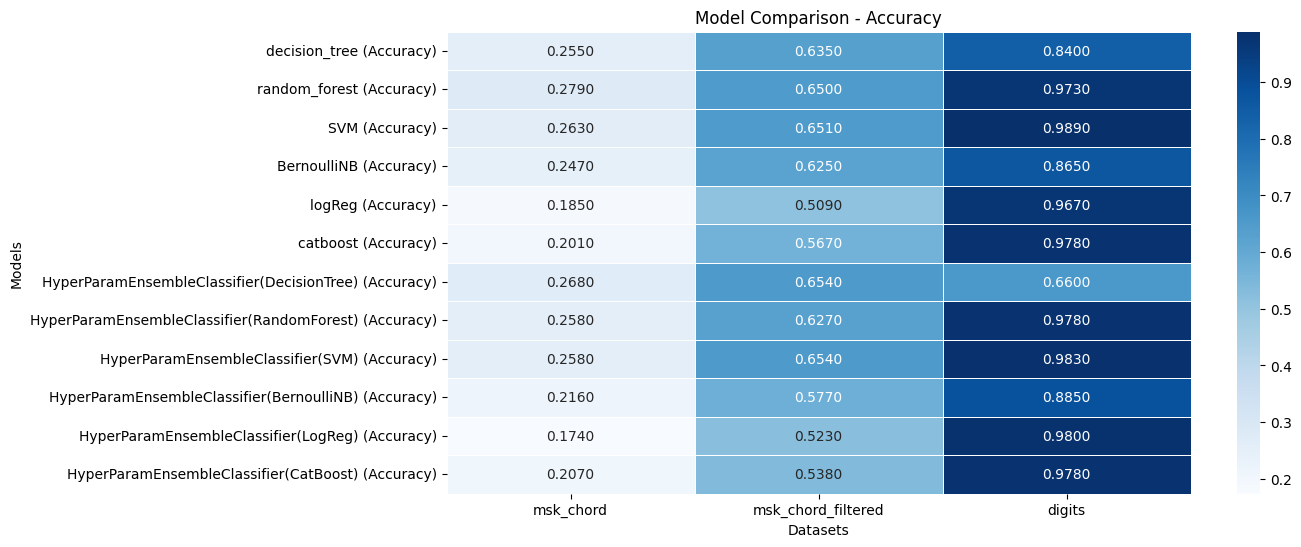

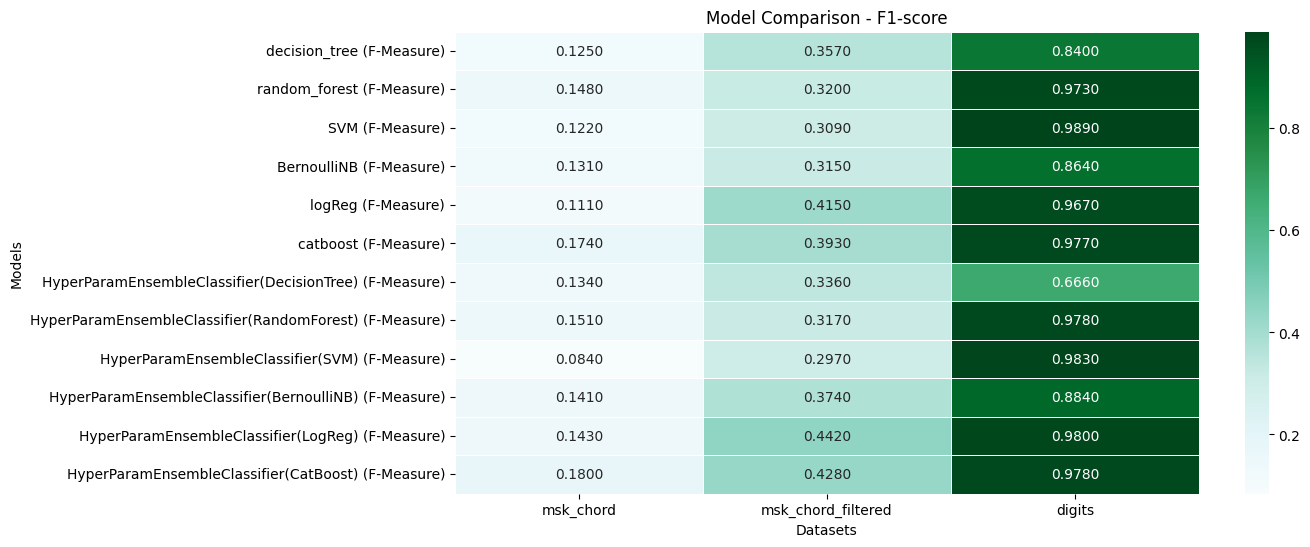

In [17]:
## Comparing Models
data = []
# We sort through the results by datasets and models
for dataset_name, models_results in data_model_evaluation_results.items():
    row_data = {"Dataset": dataset_name}
    for model_name, metrics in models_results.items():
        row_data[f"{model_name} (Accuracy)"] = f"{metrics.get('final_cv_mean', 0):.3f}"
        row_data[f"{model_name} (F-Measure)"] = f"{metrics.get('final_f1_mean', 0):.3f}"
    data.append(row_data)  # Add a line to the list

results_df = pd.DataFrame(data).set_index("Dataset") # Convert the list to a DataFrame and output
print(tabulate(results_df.T, headers='keys', tablefmt='grid'))

# Split the DataFrame into two parts: Accuracy only and F1-score only
accuracy_df = results_df.filter(like="Accuracy").T.astype(float)
f1_df = results_df.filter(like="F-Measure").T.astype(float)

# Creating a heatmap for Accuracy
plt.figure(figsize=(12, 6))
sns.heatmap(accuracy_df, annot=True, fmt=".4f", cmap="Blues", linewidths=0.5)
plt.title("Model Comparison - Accuracy")
plt.xlabel("Datasets")
plt.ylabel("Models")
plt.show()

# Creating a heatmap for F1-score
plt.figure(figsize=(12, 6))
sns.heatmap(f1_df, annot=True, fmt=".4f", cmap="BuGn", linewidths=0.5)
plt.title("Model Comparison - F1-score")
plt.xlabel("Datasets")
plt.ylabel("Models")
plt.show()


=== Accuracy ===
Friedman Test p-value: 1.0
Average Ranks:
 decision_tree (Accuracy)                                  7.333333
random_forest (Accuracy)                                  4.000000
SVM (Accuracy)                                            2.333333
BernoulliNB (Accuracy)                                    8.000000
logReg (Accuracy)                                        10.333333
catboost (Accuracy)                                       7.666667
HyperParamEnsembleClassifier(DecisionTree) (Accuracy)     5.000000
HyperParamEnsembleClassifier(RandomForest) (Accuracy)     4.666667
HyperParamEnsembleClassifier(SVM) (Accuracy)              2.333333
HyperParamEnsembleClassifier(BernoulliNB) (Accuracy)      8.333333
HyperParamEnsembleClassifier(LogReg) (Accuracy)           8.666667
HyperParamEnsembleClassifier(CatBoost) (Accuracy)         7.666667
dtype: float64


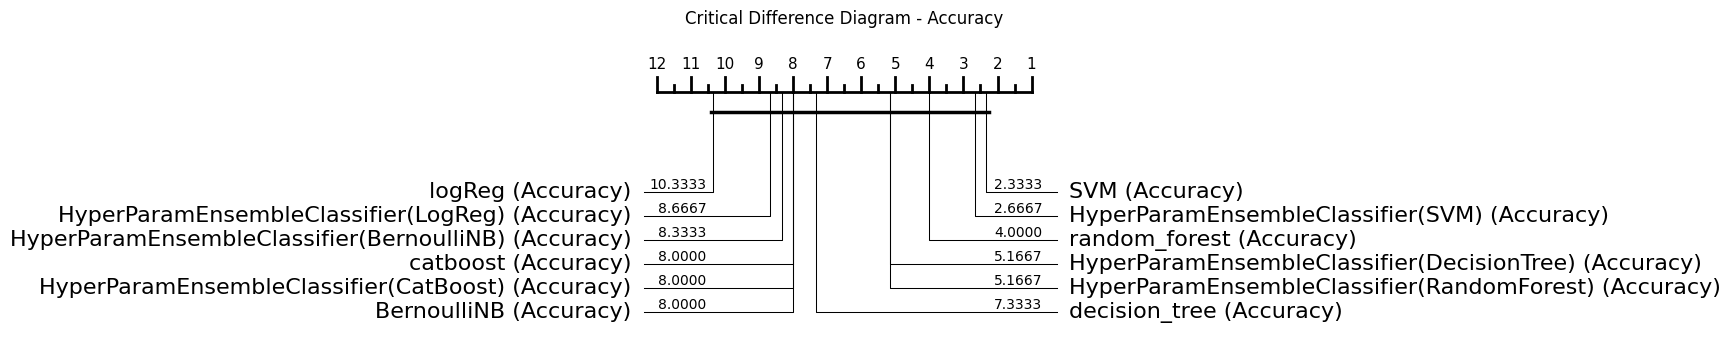


=== F1-score ===
Friedman Test p-value: 1.0
Average Ranks:
 decision_tree (F-Measure)                                 8.666667
random_forest (F-Measure)                                 6.333333
SVM (F-Measure)                                           7.333333
BernoulliNB (F-Measure)                                   9.333333
logReg (F-Measure)                                        7.333333
catboost (F-Measure)                                      4.000000
HyperParamEnsembleClassifier(DecisionTree) (F-Measure)    8.666667
HyperParamEnsembleClassifier(RandomForest) (F-Measure)    5.333333
HyperParamEnsembleClassifier(SVM) (F-Measure)             8.666667
HyperParamEnsembleClassifier(BernoulliNB) (F-Measure)     6.666667
HyperParamEnsembleClassifier(LogReg) (F-Measure)          3.000000
HyperParamEnsembleClassifier(CatBoost) (F-Measure)        2.333333
dtype: float64


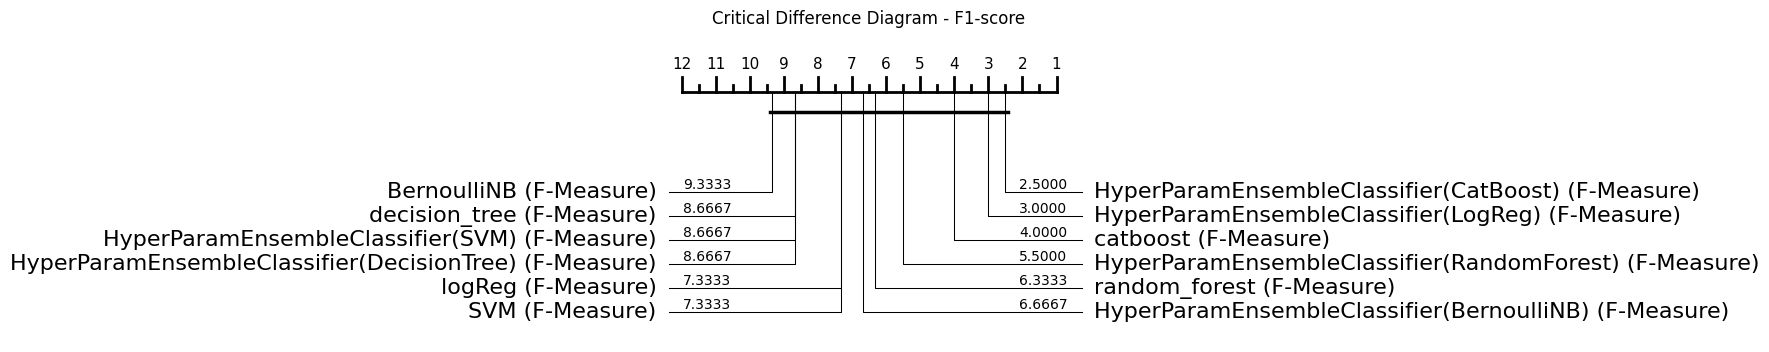

In [18]:
# Plot Critical Difference Diagram with Friedman and Nemenyi Test
# Metric matrices (raw scores, not ranks!)
acc_scores = results_df.filter(like="Accuracy").astype(float)
f1_scores  = results_df.filter(like="F-Measure").astype(float)

def analyze_and_plot_cd_from_scores(scores_df, metric_name):
    """
    Friedman + Nemenyi + CD plot using RAW metrics.
    Notes:
      - Higher metric value = better.
      - Ranks: smaller is better (1 = best).
      - CD diagram ranks internally and shows better models to the RIGHT.
    """
    print(f"\n=== {metric_name} ===")

    # Friedman test on raw metrics (across datasets)
    friedman_p_value = aeon.benchmarking.stats.check_friedman(scores_df.values)
    print(f"Friedman Test p-value: {friedman_p_value}")

    # Ranks for reporting only (not used for the CD plot)
    ranks_df = scores_df.rank(method="min", ascending=False, axis=1)
    avg_ranks = ranks_df.mean(axis=0)
    print("Average Ranks:\n", avg_ranks)

    # Nemenyi test: pass the number of datasets (rows)
    n_datasets = scores_df.shape[0]
    aeon.benchmarking.stats.nemenyi_test(avg_ranks.values, n_datasets, 0.05)

    # CD diagram: pass RAW metrics; the function computes ranks internally
    aeon.visualisation.plot_critical_difference(
        scores_df.values,
        scores_df.columns,
        test="Nemenyi")
    plt.title(f"Critical Difference Diagram - {metric_name}")
    plt.show()

analyze_and_plot_cd_from_scores(acc_scores, "Accuracy")
analyze_and_plot_cd_from_scores(f1_scores, "F1-score")

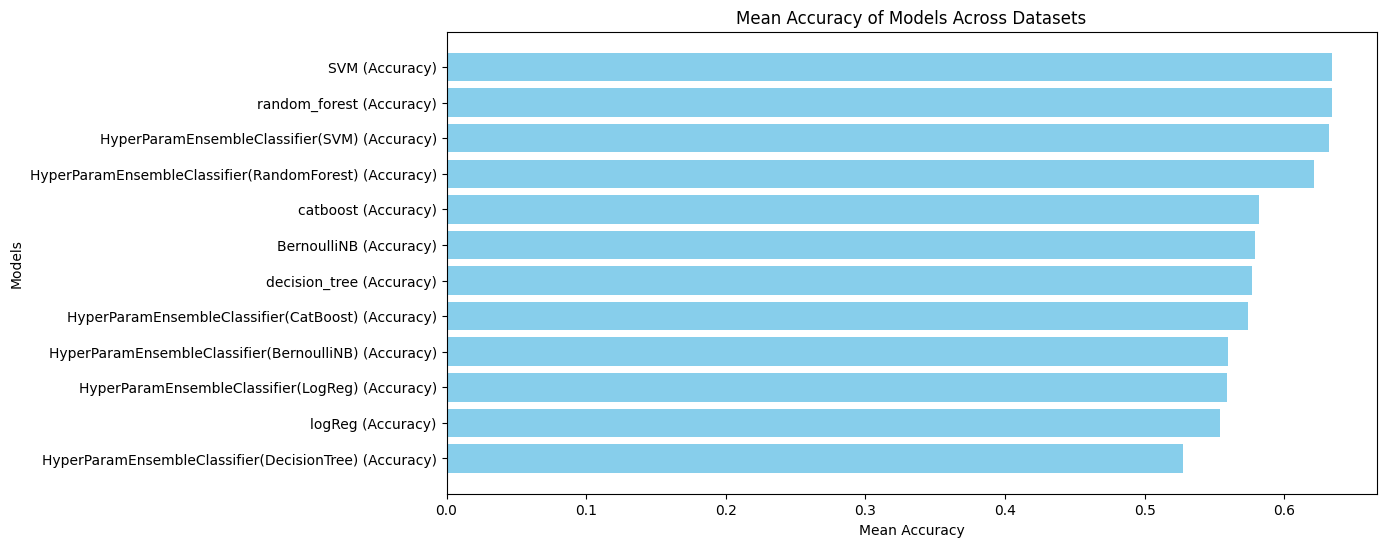

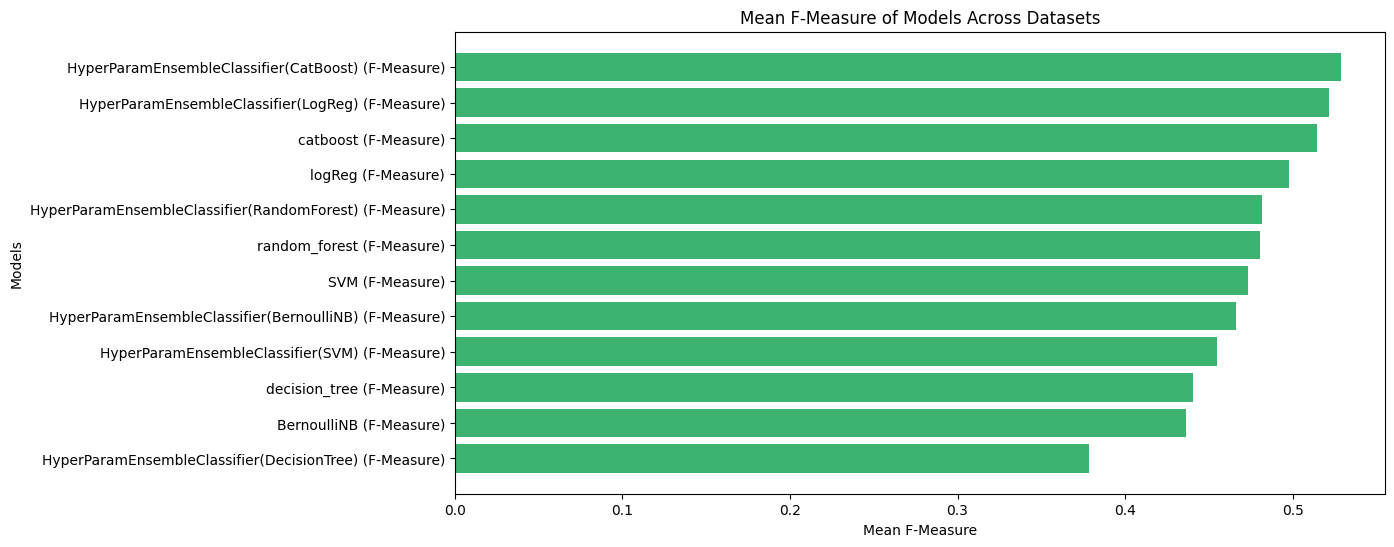

In [19]:
# Bar Chart

# Convert data to numbers
results_df = results_df.apply(pd.to_numeric, errors='coerce')

# Function for plotting graphs
def plot_metric(metric_name, color):
    metric_df = results_df.filter(like=metric_name)
    mean_values = metric_df.mean().sort_values()

    plt.figure(figsize=(12, 6))
    plt.barh(mean_values.index, mean_values.values, color=color)
    plt.xlabel(f"Mean {metric_name}")
    plt.ylabel("Models")
    plt.title(f"Mean {metric_name} of Models Across Datasets")
    plt.show()

# Building graphs for Accuracy and F1-score
plot_metric("Accuracy", "skyblue")
plot_metric("F-Measure", "mediumseagreen")